In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
q   = 1.6e-19 * np.array([1.0,-1.0])   # Ionic charges in Coulomb; Na+, Cl-
mu  = np.array([5.19e-8, 7.91e-8])     # Ionic mobility in water at 25C; in m**2 s**-1 V**-1
E   = 1e8                              # Electric Field in V/m
kBT  = 1.38e-23 * 298                  # Boltzmann's constant in J/K * temperature (for diffusion coeff calc)

# The following two only matter for sanity checks:
eta = 8.9e-4                           # dynamic viscosity of water in Pa s
avo = 6.02e23                          # Avogadro's number

zeta = np.abs(q/mu)                    # friction coefficient in kg/s
drift_velocity = q*E/zeta              # in m/s
r_hydro = zeta/(6*np.pi*eta)           # hydrodynamic radii in meters
mol_conductivity = np.abs(mu * q * avo)# molar conductivity in S m**2/mole
D = kBT/zeta                           # ionic diffusion constants in m**2/s

In [3]:
print(f"Sanity check (1): Effective hydrodynamic radii: {r_hydro[0]*1e10:.2f} and {r_hydro[1]*1e10:.2f} Angstrom")
print("Expect a few Angstroms!\n")

print(f"Sanity check (2): Molar conductivities: {mol_conductivity[0]*1e4:.2f} and {mol_conductivity[1]*1e4:.2f} S cm**2/mole")
print("Expect 50 for Na+ and around 76 for Cl-\n")

print(f"Sanity check (3): Ion diffusion constants: {D[0]:.2E} and {D[1]:.2E} m**2/s")
print("Expect around 1-2 E-9 m**2/s!\n")

print(f"Drift velocity at an electric field of {E:.1E} V/m: {drift_velocity[0]:.1f} and {drift_velocity[1]:.1E} m/s")

Sanity check (1): Effective hydrodynamic radii: 1.84 and 1.21 Angstrom
Expect a few Angstroms!

Sanity check (2): Molar conductivities: 49.99 and 76.19 S cm**2/mole
Expect 50 for Na+ and around 76 for Cl-

Sanity check (3): Ion diffusion constants: 1.33E-09 and 2.03E-09 m**2/s
Expect around 1-2 E-9 m**2/s!

Drift velocity at an electric field of 1.0E+08 V/m: 5.2 and -7.9E+00 m/s


In [4]:
def simulate_random_walkers(T, n_walkers, var_per_step):
#     print(var_per_step)
    random_steps = np.random.normal(0,1,(T, n_walkers))
    positions    = np.cumsum(random_steps,axis=0)
    return np.sqrt(var_per_step) * positions

In [5]:
time_step    = 0.5e-12                     # timestep in seconds
total_time   = 2e-9                      # total simulation time in seconds
box_dim      = 1e-8                      # We'll use a cubic box of 100 by 100 by 100 A
box_vol      = box_dim**3
conc         = np.array([0.172, 0.172])    # Concentrations in moles/liter

num_time     = np.ceil(total_time/time_step).astype(int)   # number of timepoints
timepoints   = np.arange(0, num_time) * time_step          # timepoints in seconds
var_per_step = 2*D*time_step                               # this will differ between ionic species 

n_ion        = np.ceil(1e3 * conc * box_dim**3 * avo).astype(int)  # 1e3 converts to moles/m**3
expected_current_density = np.sum(n_ion * q * drift_velocity)/box_vol
expected_conductivity_A  = expected_current_density/E 
expected_conductivity_B  = np.sum(n_ion * mol_conductivity)/(avo * box_vol)

print(f"Number of ions of each type in the simulation box: {n_ion}.")
print(f"Number of timepoints: f{timepoints.shape}\n")

print(f"Sanity checks:")
print(f"Expected current density:                        {expected_current_density:.2E} A/m**2")
print(f"Expected conductivity (from current density):    {expected_conductivity_A:.2E} S/m")
print(f"Expected conductivity (from molar conductivity): {expected_conductivity_B:.2E} S/m")

Number of ions of each type in the simulation box: [104 104].
Number of timepoints: f(4001,)

Sanity checks:
Expected current density:                        2.18E+08 A/m**2
Expected conductivity (from current density):    2.18E+00 S/m
Expected conductivity (from molar conductivity): 2.18E+00 S/m


In [6]:
ion_positions = {}
mean_position = {}
for ion_type in range(n_ion.size):
    n_walkers = 3*n_ion[ion_type]               # dimensions along which we'll have random walks (x,y,z for each ion)
    ion_positions[ion_type] = simulate_random_walkers(num_time, n_walkers, var_per_step[ion_type])
    ion_positions[ion_type] = ion_positions[ ion_type].transpose().reshape(n_ion[ion_type],3,-1)
    mean_position[ion_type] = drift_velocity[ion_type] * timepoints
    for ion in range(n_ion[ion_type]):
        ion_positions[ion_type][ion,0,:] = ion_positions[ion_type][ion,0,:] + mean_position[ion_type]

# ion_positions is a dictionary. for each ion type in the simulation, it has shape (#ions, xyz_dimensions, timepoints)
print(ion_positions[ion_type].shape)

(104, 3, 4001)


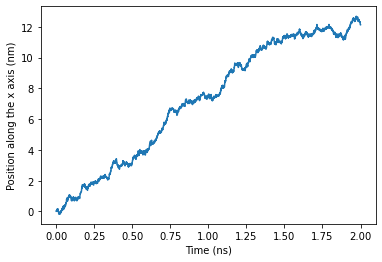

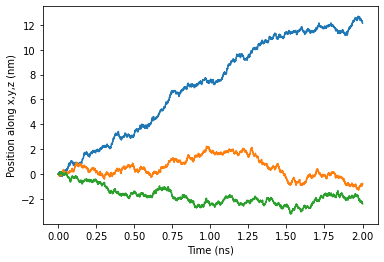

In [7]:
my_ion_type = 0   # ion type index
my_ion_index = 2  # the number of the ion (its label)
my_xyz_dim   = 0  # x=0,y=1,z=2
xyz_dims = {0:'x', 1:'y',2:'z'}

plt.plot(timepoints/1e-9, ion_positions[my_ion_type][my_ion_index,my_xyz_dim,:]/1e-9)
plt.xlabel("Time (ns)")
plt.ylabel(f"Position along the {xyz_dims[my_xyz_dim]} axis (nm)")
plt.show()

plt.plot(timepoints/1e-9, ion_positions[my_ion_type][my_ion_index,:,:].transpose()/1e-9)
plt.xlabel("Time (ns)")
plt.ylabel(f"Position along x,y,z (nm)")
plt.show()